# GIF_code  
The sole purpose of this notebook is to create a gif animation of the contagion dynamics. 

In [ ]:
import numpy as np
from numpy import random
import pandas as pd
import random
import collections
import matplotlib.pyplot as plt
from itertools import combinations
import glob
from PIL import Image
import matplotlib.animation as animation

In [2]:
main_colors = ['#c00000', '#2f5597', '#548235']
light_colors = ['#ff9797', '#b4c7e7', '#c5e0b4']

We need to change the run method from the main notebook in order to save each node's statuses through the simulation.

In [ ]:
#Model
class Model():
    def __init__(self, simplices):
        
        #Structure
        self.simplices = simplices
        self.nodes = list({node for simplex in simplices for node in simplex}) 
        self.N = len(self.nodes)

        #Time
        self.t = 0
    
    def SetInitialConditions(self, beta, p, n_A, verbose=False):

        #params
        self.beta = beta
        self.p = p

        #nodes' vocabularies (opinions)
        self.opinions = {}

        #Generating the committed minority 
        N_p = int(self.N*self.p) #number of committed individuals
        committed = random.sample(self.nodes, N_p) #random sample to create the committed agents
        for n in self.nodes:
            if n in committed:
                self.opinions[n]=frozenset(["A"]) #the committed individuals do not change their mind
        
        #Computing the size of intial communities
        N_A = int(self.N*n_A)
        N_B = self.N - N_A - N_p

        #Assigning opinions to individual agents 
        opinions_to_assign = ['A']*N_A + ['B']*N_B #create a list of opinions that follows the communities' sizes
        random.shuffle(opinions_to_assign) #shuffle the list
        noncommitted = set(self.nodes)-set(committed) #create a set for the non committed individuals
        for n, o in zip(noncommitted, opinions_to_assign):
            self.opinions[n]=set(o)
        
        #Expliciting the output if requested
        if verbose: print('Setup done.', self.N, 'nodes', "N_A:", N_A, "N_B:", N_B, "N_p:", N_p)

    def AgreeOnSimplex(self, simplex, said_word):
        
        for n in simplex:
            try: #we use try because committed individuals have frozenset
                self.opinions[n].clear()
                self.opinions[n].add(said_word)
            except AttributeError: #It was a committed individual
                pass
    
    def ListenersLearnWord(self, listeners, said_word):
        for listener in listeners:
            try:
                self.opinions[listener].add(said_word)
            except AttributeError: #It was a committed individual
                pass
    
    def PlayOnSimplex(self, simplex):

        #Selecting speaker and listeners at random
        random.shuffle(simplex)
        speaker = simplex[0]
        listeners = simplex[1:]

        #Selecting a random word from the speaker's vocabulary to be said
        said_word = random.choice(list(self.opinions[speaker]))
        words_of_listeners = [self.opinions[listener] for listener in listeners]
        
        #Getting the words of listeners to be used for the agreement
        words_of_listeners_by_rule = set.intersection(*[set(w) for w in words_of_listeners])

        #Trying to agree acoording to the unanimity condition rule
        if (said_word in words_of_listeners_by_rule) and (random.random() <= self.beta):
            self.AgreeOnSimplex(simplex, said_word)
        else:
            self.ListenersLearnWord(listeners, said_word)

    def GetDensities(self):
        single_opinion_counter = collections.Counter([list(opinions)[0] for opinions in self.opinions.values() if len(opinions)==1])
        n_Ap = single_opinion_counter["A"]/self.N
        n_B = single_opinion_counter["B"]/self.N
        n_AB = 1 - n_Ap - n_B
        return n_Ap, n_B, n_AB
    
    def detailed_run(self, path, t_max=100, check_every=10, print_every=1, opinions_every=10):

        self.t_max = t_max

        #Opening file to save densities results
        densities_path = path + 'detailed_simulation_densities_N%i_beta%.4f_p%.2f.csv'%(self.N, self.beta, self.p)
        f = open(densities_path, 'w')
        f.write('time,n_A+p,n_B,n_AB\n')

        #Opening file to save opinion evolution
        opinions_path = path + 'detailed_simulation_opinions_N%i_beta%.4f_p%.2f.csv'%(self.N, self.beta, self.p)
        initial_opinions_dict = {node: str(self.opinions[node]) for node in self.nodes}
        opinions_df = pd.DataFrame([initial_opinions_dict], index=[0])
        opinions_df.to_csv(opinions_path, mode='w', index=True)


        while self.t <= self.t_max:
            self.t += 1
            if self.t%print_every==0: print('t=%i'%self.t)
            
            #Selecting a random simplex to be played on
            simplex = random.choice(self.simplices)

            #Playing on simplex
            self.PlayOnSimplex(simplex)

            #Storing the node statuses every opinions_every time steps
            if self.t%opinions_every==0:
                current_opinions_dict = {node: str(self.opinions[node]) for node in self.nodes}
                opinions_df = pd.DataFrame([current_opinions_dict], index=[self.t])
                opinions_df.to_csv(opinions_path, mode='a', header=False, index=True)            

            #Storing the values every check_every time steps
            if self.t%check_every==0:
                n_Ap, n_B, n_AB = self.GetDensities()
                line = "%i,%.3f,%.3f,%.3f\n"%(self.t, n_Ap, n_B, n_AB)
                f.write(line)
                
                #Checking if we reached the absorbing state in order to interrupt the simulation
                if n_Ap==1 or n_B==1:
                    f.close()   
                    print('Done! Reached the absorbing state.')
                    return None
                
        f.close()    
        print('Done! No more time left')
    
    def ReturnFilepath(self, path):
        
        results_filepath = path + 'detailed_simulation_densities_N%i_beta%.4f_p%.2f.csv'%(self.N, self.beta, self.p)
        return results_filepath

Let's run the simulation once for a uniform $k$-hypergraph.

In [ ]:
def k_hypergraph_creator(N,k=3):
    nodes = range(N)
    simplices = list(combinations(nodes,k)) #generates all possible combination made by k nodes
    simplices = [list(simplex) for simplex in simplices]
    return simplices

In [ ]:
N = 100
k = 3
simplices = k_hypergraph_creator(N,k)

In [12]:
beta = 0.3
p = 0.01
n_A = 0

output_path = "./Simulation_Results/HomMix_Hypergraph/"
t_max = 1e5

check_every = 1
print_every = 1
opinions_every = 1

simulation = Model(simplices)
simulation.SetInitialConditions(beta, p, n_A, verbose=True)
simulation.detailed_run(output_path, t_max, check_every, opinions_every)

Setup done. 100 nodes N_A: 0 N_B: 99 N_p: 1
t=1
t=2
t=3
t=4
t=5
t=6
t=7
t=8
t=9
t=10
t=11
t=12
t=13
t=14
t=15
t=16
t=17
t=18
t=19
t=20
t=21
t=22
t=23
t=24
t=25
t=26
t=27
t=28
t=29
t=30
t=31
t=32
t=33
t=34
t=35
t=36
t=37
t=38
t=39
t=40
t=41
t=42
t=43
t=44
t=45
t=46
t=47
t=48
t=49
t=50
t=51
t=52
t=53
t=54
t=55
t=56
t=57
t=58
t=59
t=60
t=61
t=62
t=63
t=64
t=65
t=66
t=67
t=68
t=69
t=70
t=71
t=72
t=73
t=74
t=75
t=76
t=77
t=78
t=79
t=80
t=81
t=82
t=83
t=84
t=85
t=86
t=87
t=88
t=89
t=90
t=91
t=92
t=93
t=94
t=95
t=96
t=97
t=98
t=99
t=100
t=101
t=102
t=103
t=104
t=105
t=106
t=107
t=108
t=109
t=110
t=111
t=112
t=113
t=114
t=115
t=116
t=117
t=118
t=119
t=120
t=121
t=122
t=123
t=124
t=125
t=126
t=127
t=128
t=129
t=130
t=131
t=132
t=133
t=134
t=135
t=136
t=137
t=138
t=139
t=140
t=141
t=142
t=143
t=144
t=145
t=146
t=147
t=148
t=149
t=150
t=151
t=152
t=153
t=154
t=155
t=156
t=157
t=158
t=159
t=160
t=161
t=162
t=163
t=164
t=165
t=166
t=167
t=168
t=169
t=170
t=171
t=172
t=173
t=174
t=175
t=176
t=177
t=

We first need to choose which frames to show in the GIF.

In [64]:
opinions_csv_path='./Simulation_Results/HomMix_Hypergraph/detailed_simulation_opinions_N%i_beta%.4f_p%.2f.csv'%(N, beta, p)
opinions_df = pd.read_csv(opinions_csv_path, index_col=0, dtype=object)

In [91]:
#print(opinions_df.head(3))

In [92]:
#print(opinions_df)

In [ ]:
N=len(opinions_df.columns)
grid_size = int(np.ceil(np.sqrt(N)))
print(f'grid_size: {grid_size}')

df_len = len(opinions_df)
num_frames = 60

if df_len >= num_frames:
    print("Automatic choiche of time frames enabled.")
    time_stamp_float_list = np.linspace(0, df_len-1, num_frames)
    time_stamp_int_list = sorted(list(set(int(x) for x in time_stamp_float_list))) #we take num_frames evenly spaced rows in the opinions dataframe
    actual_time_stamp_list = [t*10 for t in time_stamp_int_list] #the mulitplication by a 10 factor is due to the nature of how I generated the dataset, be aware (it occures more than once in the following code) 
else:
    time_stamp_int_list = list(range(num_frames))

print(time_stamp_int_list)

grid_size: 10
Automatic choiche of time frames enabled.
[0, 45, 90, 135, 180, 226, 271, 316, 361, 407, 452, 497, 542, 588, 633, 678, 723, 769, 814, 859, 904, 949, 995, 1040, 1085, 1130, 1176, 1221, 1266, 1311, 1357, 1402, 1447, 1492, 1538, 1583, 1628, 1673, 1719, 1764, 1809, 1854, 1899, 1945, 1990, 2035, 2080, 2126, 2171, 2216, 2261, 2307, 2352, 2397, 2442, 2488, 2533, 2578, 2623, 2669]


We now create the images for each timestamp.

In [ ]:
color_map = {
        "frozenset({'A'})": "purple",
        "{'A'}": "#c00000",
        "{'B'}": "#2f5597",
        "{'A', 'B'}": "#548235",  
        "{'B', 'A'}": "#548235",  
    }

saving_path = './Figures/GIF_Frames_Storage/HomMix_Hypergraph/'

j=0

for i in time_stamp_int_list:
    fig, ax = plt.subplots()
    plt.title(rf"$t = {i*10}$")
    for row in range(grid_size):
        for col in range(grid_size):
            df_index = row * grid_size + col #node identification number
            value = opinions_df.iloc[i, df_index]
            color = color_map.get(value, "lightgray")
            rect = plt.Rectangle((col, row), 1, 1, linewidth=1, edgecolor="black", facecolor=color)
            ax.add_patch(rect)
            #Adding text to number the squares
            x_center = col + 0.5
            y_center = row + 0.5
            text = f"{df_index+1}"
            ax.text(x_center, y_center, text, ha='center', va='center', fontsize = 8, color = 'white')
            
    ax.set_xlim(0, grid_size)
    ax.set_ylim(grid_size, 0)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    #saving
    filename = f'nodes_status_N{N:04d}_beta{beta:.4f}_p{p:.2f}_time{i*10:06d}.png'
    plt.savefig(saving_path+filename)
    plt.close(fig) #we don't need to show the frames here
    j += 1
    if j%10 == 0:
        print(f"Saved {j} frames.")

print("Done!")

Saved 10 frames.
Saved 20 frames.
Saved 30 frames.
Saved 40 frames.
Saved 50 frames.
Saved 60 frames.
Done!


We finally create the .gif animation from the previous stills.  

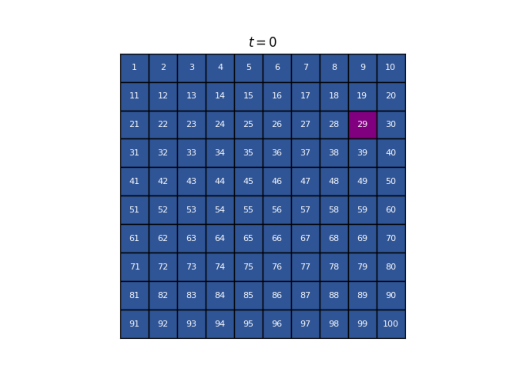

MovieWriter ffmpeg unavailable; using Pillow instead.


In [ ]:
#we load all the images generated in the previous cell
frame_files = glob.glob(r'./Figures/GIF_Frames_Storage/HomMix_Hypergraph/*.png')
frame_array = []

for file in frame_files:
    image = Image.open(file)
    frame_array.append(image)

fig, ax = plt.subplots()

im = ax.imshow(frame_array[0], animated=True)

def update(i):
    im.set_array(frame_array[i])
    return im,

ax.axis('off')

animation_fig = animation.FuncAnimation(fig, update, frames=len(frame_array), interval=500, blit=True, repeat_delay=1000)
plt.show()

save_path = './Figures/GIF_N%i_beta%.4f_p%.2f.gif'%(N, beta, p)
animation_fig.save(save_path)


We can also plot the densities evolution with light-grey bars signaling the timestamps pictured in the animation.

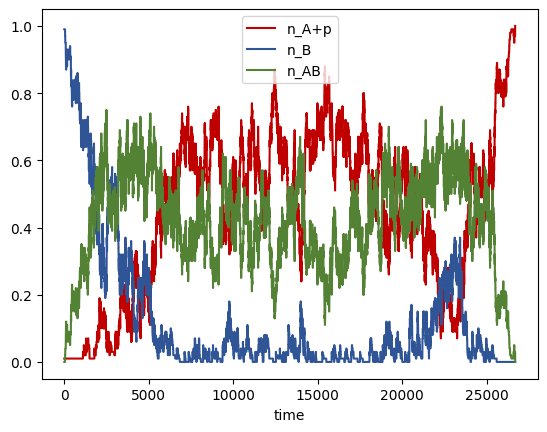

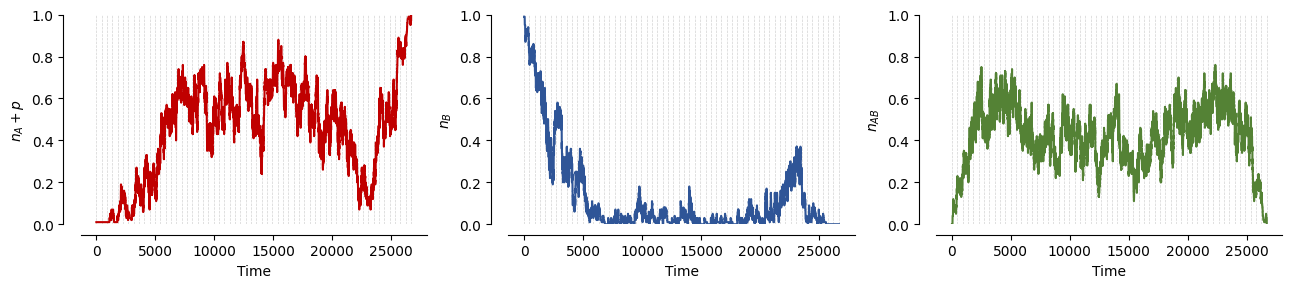

In [103]:
#results_filepath = simulation.ReturnFilepath(output_path)
results_filepath = './Simulation_Results/HomMix_Hypergraph/detailed_simulation_densities_N%i_beta%.4f_p%.2f.csv'%(N, beta, p)
densities_df = pd.read_csv(results_filepath)
densities_df.plot(x='time', color=main_colors)

################## Dividing in three subplots to make it more readable ##################

fig, ax=plt.subplots(1,3, figsize=(13,3))
ylabels_df=['n_A+p', 'n_B', 'n_AB']
ylabels=['n_A+p', 'n_B', 'n_{AB}']
for i in [0,1,2]:
    for x in actual_time_stamp_list:
        ax[i].axvline(x, color='lightgrey', linestyle='--', linewidth = 0.5)
    ax[i].plot(densities_df['time'], densities_df[ylabels_df[i]], color=main_colors[i])
    ax[i].set_ylim(0,1)
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel(rf'${ylabels[i]}$')


#################################### Adjusting ticks #################################### 
for i in [0,1,2]:
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].spines['bottom'].set_position(('axes', -0.05))
    ax[i].yaxis.set_ticks_position('left')
    ax[i].spines['left'].set_position(('axes', -0.05))
            
plt.tight_layout()
plt.show()